### Contexto
Eres analista en una gran tienda online. Junto con el departamento de marketing has recopilado una lista de hipótesis que pueden ayudar a aumentar los ingresos.

Tienes que priorizar estas hipótesis, lanzar un test A/B y analizar los resultados.

### Parte 1. Priorizar hipótesis

El archivo hypotheses_us.csv contiene nueve hipótesis sobre cómo aumentar los ingresos de una tienda online con Reach, Impact, Confidence y Effort especificados para cada una.

El ejercicio consiste en:

Aplicar el framework ICE para priorizar hipótesis y ordenarlas de forma descendente de prioridad.
Aplicar el framework RICE para priorizar hipótesis y ordenarlas de forma descendente de prioridad.
Mostrar cómo cambia la priorización de hipótesis cuando utilizas RICE en lugar de ICE. Proporcionar una explicación de los cambios.

In [39]:
# Importar librerias necesarias 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import math as mth
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import mannwhitneyu


In [40]:
# Cargar los datasets

df_hipotesis = pd.read_csv('hypotheses_us.csv', sep=';')

df_orders = pd.read_csv('orders_us.csv')

df_visits = pd.read_csv('visits_us.csv')

In [41]:
# Limpiar df_hipotesis

df_hipotesis.info()

# limpiar df_orders
df_orders['date'] = pd.to_datetime(df_orders['date'], format='%Y-%m-%d') # transformar la columna date a datetime

# Limpiar df_visits
df_visits['date'] = pd.to_datetime(df_visits['date'], format='%Y-%m-%d') # transformar la columna date a datetime


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes


In [42]:
# Confirmar que no haya errores en los datos
df_orders_copy = df_orders.copy() # clonar el dataframe df_orders en un nuevo dataframe df_orders_clean
visitors_A = set(df_orders[df_orders['group'] == 'A']['visitorId']) # obtener los visitantes del grupo A
visitors_B = set(df_orders[df_orders['group'] == 'B']['visitorId']) # obtener los visitantes del grupo B
# Verificar que no haya visitantes en ambos grupos 
intersecting_visitors = visitors_A & visitors_B # obtener los visitantes que estan en ambos grupos
# Eliminar los visitantes que estan en ambos grupos
df_orders = df_orders[~df_orders['visitorId'].isin(intersecting_visitors)] # eliminar los visitantes que estan en ambos grupos

In [43]:
# Priorizar hipotesis crear ICE y RICE con df_hipotesis
# Crear un dataframe llamado df_hipotesis_ICE a partir de df_hipotesis para puntaje ICE ordenando de mayor a menor
df_hipotesis['ICE'] = df_hipotesis['Impact'] * df_hipotesis['Confidence'] / df_hipotesis['Effort'] # calcular el puntaje ICE
df_hipotesis_ICE = df_hipotesis[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False).reset_index(drop=True) # ordenar el dataframe por ICE de mayor a menor

In [44]:
#  Crear un dataframe llamado df_hipotesis_RICE a partir de df_hipotesis para puntaje ICE ordenando de mayor a menor
df_hipotesis['RICE'] = df_hipotesis['Reach'] * df_hipotesis['Impact'] * df_hipotesis['Confidence'] / df_hipotesis['Effort'] # calcular el puntaje RICE
df_hipotesis_RICE = df_hipotesis[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False).reset_index(drop=True) # ordenar el dataframe por RICE de mayor a menor


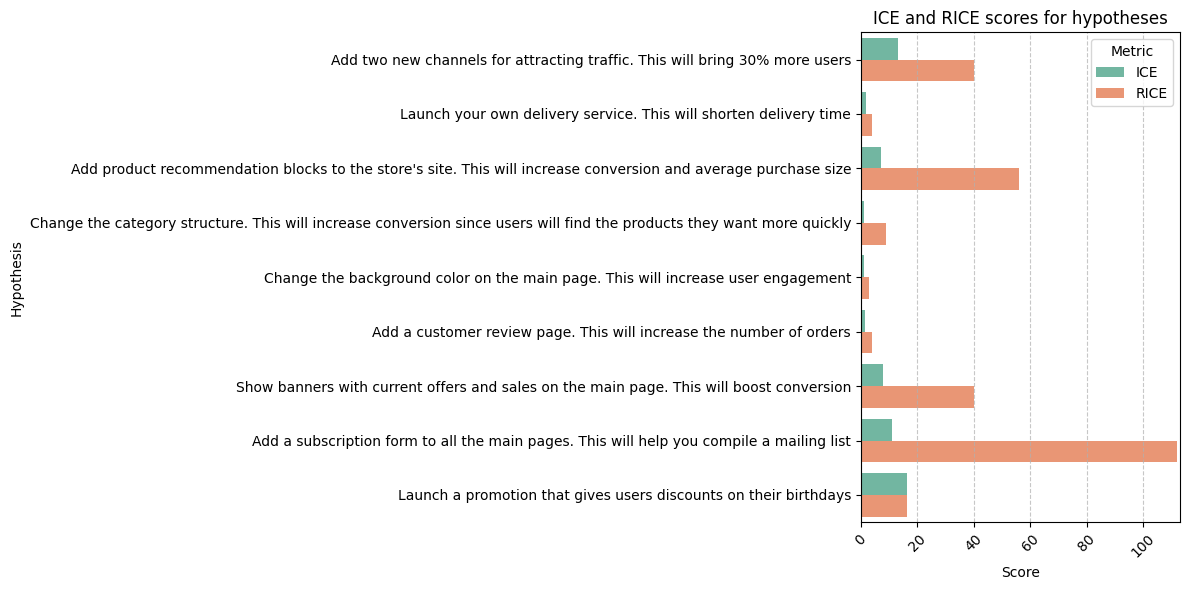

In [45]:
# Hacer una grafica comparando cada hipotesis con su puntaje ICE y RICE 
# Crear un dataframe para graficar
df_hipotesis_plot = df_hipotesis[['Hypothesis', 'ICE', 'RICE']].melt(id_vars='Hypothesis', var_name='Metric', value_name='Score') # transformar el dataframe para graficar
# Graficar
plt.figure(figsize=(12, 6))
sns.barplot(x='Score', y='Hypothesis', hue='Metric', data=df_hipotesis_plot, palette='Set2') # graficar
plt.title('ICE and RICE scores for hypotheses')
plt.xlabel('Score')
plt.ylabel('Hypothesis')
plt.legend(title='Metric')
plt.grid(axis='x', linestyle='--', alpha=0.7) # agregar una rejilla
plt.xlim(0, df_hipotesis_plot['Score'].max() + 1) # agregar un limite al eje x
plt.xticks(rotation=45) # rotar las etiquetas del eje x
plt.tight_layout() # ajustar la grafica
plt.show() # mostrar la grafica

La grafica muestra el valor ICE y RICE de cada hipotesis. Basandonos en el metrico ICE la teoria con mayor nivel de prioridad resultaria ser "Lanzar una promoción que ofrece a los usuarios descuentos en sus cumpleaños" pero con el metrico de RICE resulta ser la hipotesis con mayor prioridad la de "Añadir un formulario de suscripción a todas las páginas principales. Esto nos ayudará a crear una lista de correo" 

### Parte 2. Análisis del test A/B
Realizaste una prueba A/B y obtuviste los resultados descritos en los archivos orders_us.csv y visits_us.csv.

##### Ejercicio

1.- Representa gráficamente el ingreso acumulado por grupo. Haz conclusiones y conjeturas.

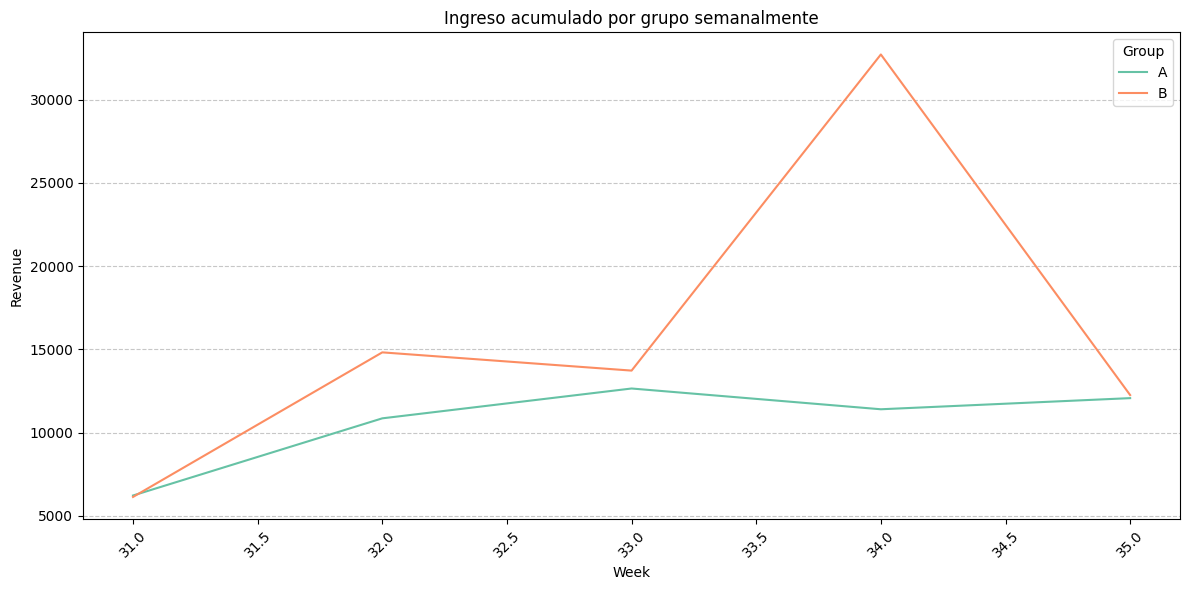

In [46]:
# Crear una grafica del ingreso acumulado por grupo

# Crear un dataframe para graficar
df_orders_group = df_orders.groupby(['date', 'group']).agg({'revenue': 'sum'}).reset_index() # agrupar por fecha y grupo mostrando la suma de ingresos por dia por grupo
# Agruparlo por semana
df_orders_group['week'] = df_orders_group['date'].dt.isocalendar().week # agregar una columna con la semana
# Agrupar por semana y grupo mostrando la suma de ingresos por semana por grupo
df_orders_group_week = df_orders_group.groupby(['week', 'group']).agg({'revenue': 'sum'}).reset_index() # agrupar por semana y grupo mostrando la suma de ingresos por semana por grupo
# Graficar
plt.figure(figsize=(12, 6))
sns.lineplot(x='week', y='revenue', hue='group', data=df_orders_group_week, palette='Set2') # graficar
plt.title('Ingreso acumulado por grupo semanalmente')
plt.xlabel('Week')
plt.ylabel('Revenue')
plt.legend(title='Group')
plt.grid(axis='y', linestyle='--', alpha=0.7) # agregar una rejilla
plt.xticks(rotation=45) # rotar las etiquetas del eje x
plt.tight_layout() # ajustar la grafica
plt.show() # mostrar la grafica

La grafica muestra los ingresos semanales de los grupos A y B. De los cuales en la semana 32, 33 y 34 encabeza el grupo B siendo la semana 31 y 35 el mismo ingreso en ambos casos. Apriori podemos determinar que en la mayoria de los casos hubo una preferencia o mayor ingresos en el grupo B. 

2.- Representa gráficamente el tamaño de pedido promedio acumulado por grupo. Haz conclusiones y conjeturas.

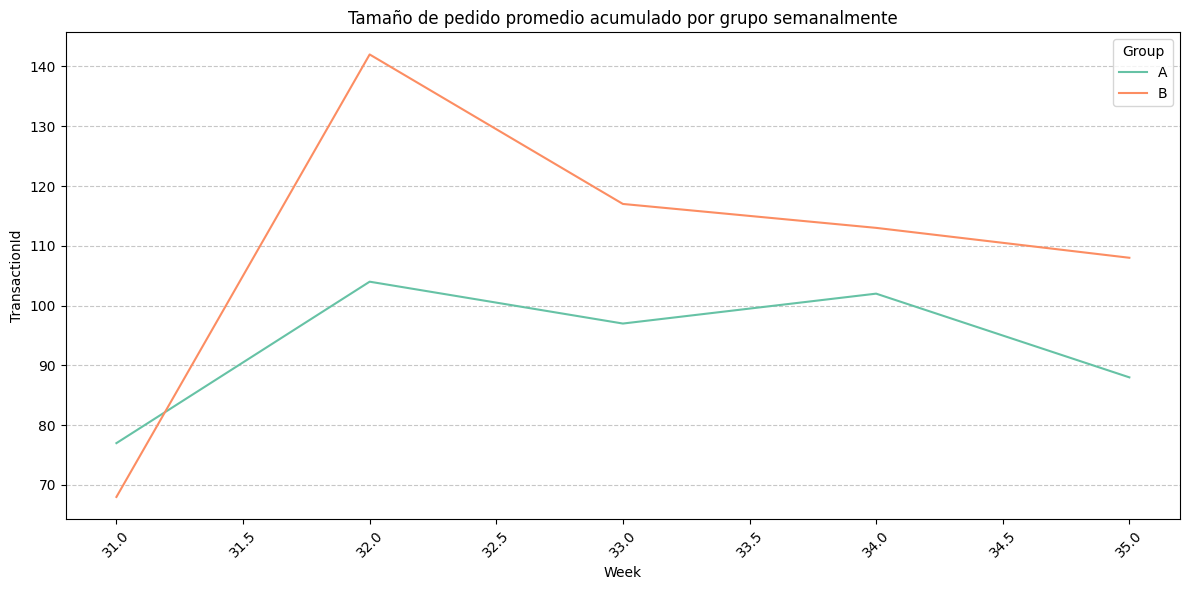

In [47]:
# Representa gráficamente el tamaño de pedido promedio acumulado por grupo. 
# Crear un dataframe para graficar
df_orders_count = df_orders.groupby(['date', 'group']).agg({'transactionId': 'count'}).reset_index() # agrupar por fecha y grupo mostrando la cantidad de pedidos por dia por grupo
# Agruparlo por semana
df_orders_count['week'] = df_orders_count['date'].dt.isocalendar().week # agregar una columna con la semana
# Agrupar por semana y grupo mostrando la cantidad de pedidos por semana por grupo
df_orders_count_week = df_orders_count.groupby(['week', 'group']).agg({'transactionId': 'sum'}).reset_index() # agrupar por semana y grupo mostrando la cantidad de pedidos por semana por grupo
# Graficar
plt.figure(figsize=(12, 6))
sns.lineplot(x='week', y='transactionId', hue='group', data=df_orders_count_week, palette='Set2') # graficar
plt.title('Tamaño de pedido promedio acumulado por grupo semanalmente')
plt.xlabel('Week')
plt.ylabel('TransactionId')
plt.legend(title='Group')
plt.grid(axis='y', linestyle='--', alpha=0.7) # agregar una rejilla
plt.xticks(rotation=45) # rotar las etiquetas del eje x
plt.tight_layout() # ajustar la grafica
plt.show() # mostrar la grafica

De la presenta grafica podemos determinar que en la semana 31 hay preferencia por el grupo A, mientras que en las demas semana, 32, 33, 34, y 35 hay preferencia por el grupo B. 

3.- Representa gráficamente la diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A. Haz conclusiones y conjeturas.

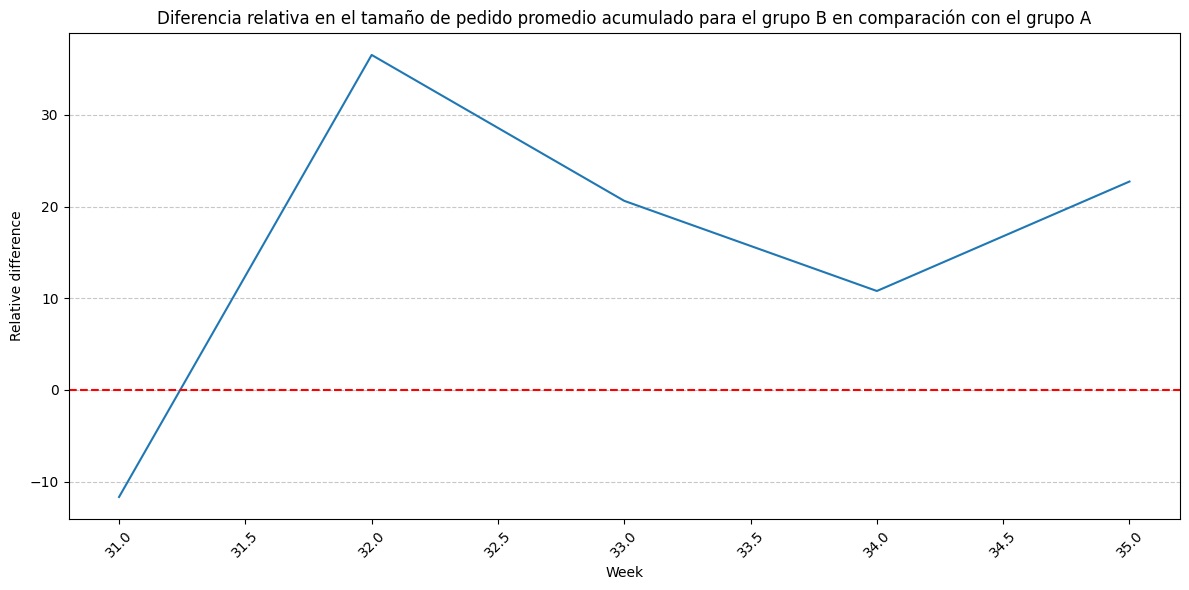

In [48]:
# Separar los grupos
df_orders_A_count = df_orders_count_week[df_orders_count_week['group'] == 'A'] # separar el grupo A 
df_orders_B_count = df_orders_count_week[df_orders_count_week['group'] == 'B'] # separar el grupo B
# unificar los dataframes cambiando el nombre de la columna transactionId por transactionId_A y transactionId_B
df_orders_count_week_seperate = df_orders_A_count.merge(df_orders_B_count, on='week', suffixes=('_A', '_B')) 
# Calcular la diferencia relativa
df_orders_count_week_seperate['relative_difference'] = (df_orders_count_week_seperate['transactionId_B'] - df_orders_count_week_seperate['transactionId_A']) / df_orders_count_week_seperate['transactionId_A'] * 100 # calcular la diferencia relativa
# Graficar por semana la diferencia relativa
plt.figure(figsize=(12, 6))
sns.lineplot(x='week', y='relative_difference', data=df_orders_count_week_seperate) # graficar
plt.title('Diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A')
plt.xlabel('Week')
plt.ylabel('Relative difference')
plt.grid(axis='y', linestyle='--', alpha=0.7) # agregar una rejilla
plt.xticks(rotation=45) # rotar las etiquetas del eje x
plt.tight_layout() # ajustar la grafica
plt.axhline(0, color='red', linestyle='--') # agregar una linea horizontal en 0
plt.show() # mostrar la grafica

La diferencia relativa con respecto al grupo B es negativa en el caso de la semana 31, mientras que en las demas es positiva.  

4.- Calcula la tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día. Representa gráficamente las tasas de conversión diarias de los dos grupos y describe la diferencia. Saca conclusiones y haz conjeturas.

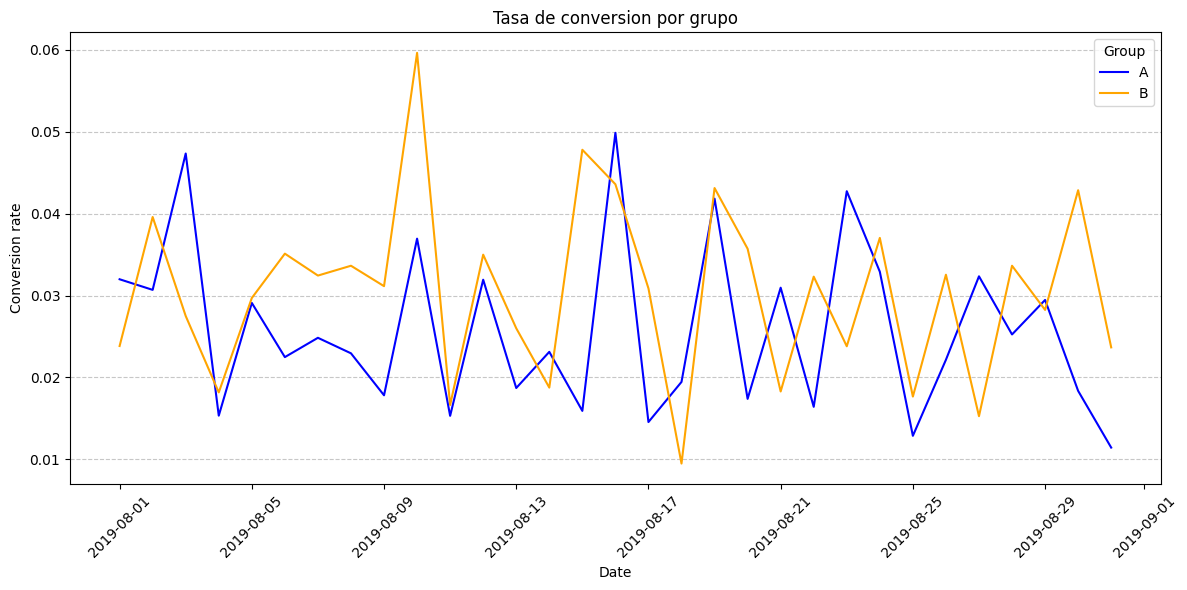

In [49]:
# Representa gráficamente la tasa de conversión por grupo. 
# Separar por grupos 
df_orders_count_A_day = df_orders_count[df_orders_count['group'] == 'A'].reset_index() # separar el grupo A
# nombrar columna transactionId por count_orders_A
df_orders_count_A_day.rename(columns={'transactionId': 'count_orders_A'}, inplace=True) # renombrar la columna transactionId por count_orders_A
df_orders_count_B_day = df_orders_count[df_orders_count['group'] == 'B'].reset_index() # separar el grupo B
# nombrar columna transactionId por count_orders_B
df_orders_count_B_day.rename(columns={'transactionId': 'count_orders_B'}, inplace=True) # renombrar la columna transactionId por count_orders_B
df_visits_A_day = df_visits[df_visits['group'] == 'A'].reset_index() # separar el grupo A
df_visits_B_day = df_visits[df_visits['group'] == 'B'].reset_index() # separar el grupo B
# Unir los dataframes por fecha 
df_orders_count_day = df_orders_count_A_day.merge(df_visits_A_day[['date', 'group', 'visits']], on=['date', 'group'], how='left') # unir por fecha y grupo
# nombrar columna visits por count_visits_A
df_orders_count_day.rename(columns={'visits': 'count_visits_A'}, inplace=True) # renombrar la columna visits por count_visits_A
# Crear una columna con la tasa de conversion
df_orders_count_day['conversion_rate'] = df_orders_count_day['count_orders_A'] / df_orders_count_day['count_visits_A'] # calcular la tasa de conversion

# Unir los dataframes por fecha de B
df_orders_count_B_day = df_orders_count_B_day.merge(df_visits_B_day[['date', 'group', 'visits']], on=['date', 'group'], how='left') # unir por fecha y grupo
# nombrar columna visits por count_visits_B
df_orders_count_B_day.rename(columns={'visits': 'count_visits_B'}, inplace=True) # renombrar la columna visits por count_visits_B
# Crear una columna con la tasa de conversion
df_orders_count_B_day['conversion_rate'] = df_orders_count_B_day['count_orders_B'] / df_orders_count_B_day['count_visits_B'] # calcular la tasa de conversion
# Unir los dataframes por fecha 
df_orders_count_day_2 = df_orders_count_day.merge(df_orders_count_B_day[['date', 'group', 'conversion_rate']], on=['date'], how='left') # unir por fecha y grupo
# graficar la tasa de conversion por grupo
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='conversion_rate_x', data=df_orders_count_day_2, label='A', color='blue') # graficar
sns.lineplot(x='date', y='conversion_rate_y', data=df_orders_count_day_2, label='B', color='orange') # graficar
plt.title('Tasa de conversion por grupo')
plt.xlabel('Date')
plt.ylabel('Conversion rate')  
plt.legend(title='Group')
plt.grid(axis='y', linestyle='--', alpha=0.7) # agregar una rejilla
plt.xticks(rotation=45) # rotar las etiquetas del eje x
plt.tight_layout() # ajustar la grafica
plt.show() # mostrar la grafica

La tasa de conversion nos indica que grupo tuvo mayor porcentaje de ventas conrespecto al numero de visitas. La grafica por dia nos muestra aparentemente que el grupo B tuvo mayores picos por lo que tuvo mayor tasa de conversion. 

5.- Traza un gráfico de dispersión del número de pedidos por usuario. Haz conclusiones y conjeturas.

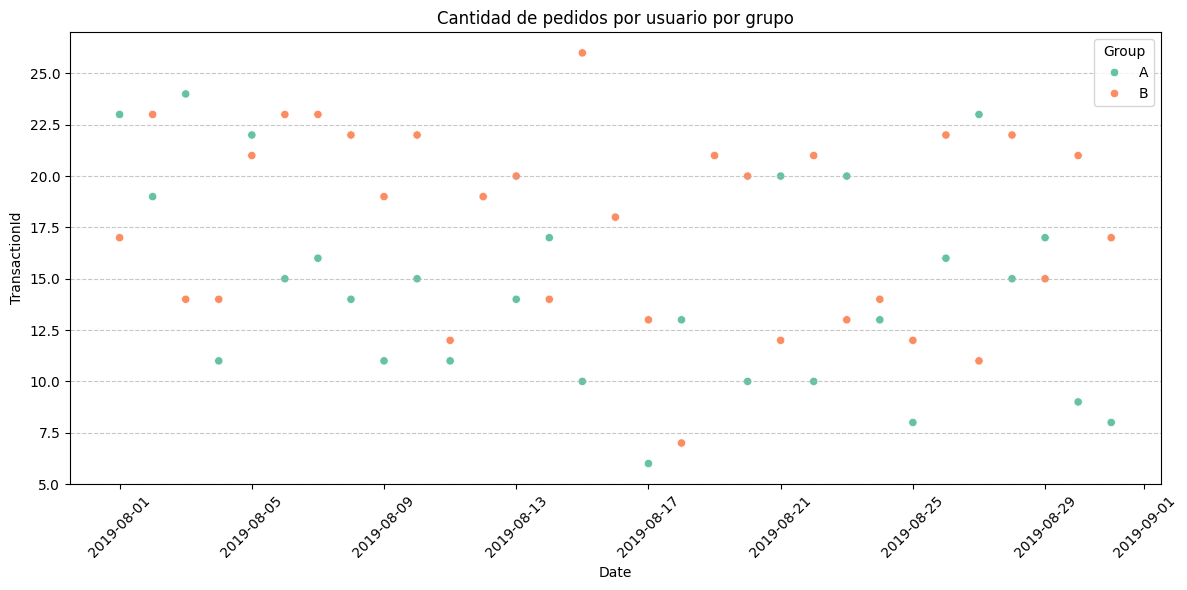

In [50]:
# Traza un gráfico de dispersión del número de pedidos por usuario. Haz conclusiones y conjeturas.
# Agrupar por usuario y grupo mostrando la cantidad de pedidos por usuario por grupo
df_orders_user = df_orders.groupby(['date', 'group']).agg({'transactionId': 'count'}).reset_index() # agrupar por usuario y grupo mostrando la cantidad de pedidos por usuario por grupo
# Realizar graficar de dispersión
plt.figure(figsize=(12, 6))
sns.scatterplot(x='date', y='transactionId', hue='group', data=df_orders_user, palette='Set2') # graficar
plt.title('Cantidad de pedidos por usuario por grupo')
plt.xlabel('Date')
plt.ylabel('TransactionId')
plt.legend(title='Group')
plt.grid(axis='y', linestyle='--', alpha=0.7) # agregar una rejilla
plt.xticks(rotation=45) # rotar las etiquetas del eje x
plt.tight_layout() # ajustar la grafica
plt.show() # mostrar la grafica

6.- Calcula los percentiles 95 y 99 del número de pedidos por usuario. Define el punto en el cual un punto de datos se convierte en una anomalía.

In [51]:
# Calcular percentiles 95 y 99 de los numeros de pedidos por usuario
# Calcular el percentil 95
percentil_95 = np.percentile(df_orders_user['transactionId'], 95) # calcular el percentil 95
print('El percentil 95 es:', percentil_95) # imprimir el percentil 95
# Calcular el percentil 99
percentil_99 = np.percentile(df_orders_user['transactionId'], 99) # calcular el percentil 99
print('El percentil 99 es:', percentil_99) # imprimir el percentil 99

El percentil 95 es: 23.0
El percentil 99 es: 24.78


Los valores encima de 23 hasta por encima de 24.78 son valores anomalos.  

7.- Traza un gráfico de dispersión de los precios de los pedidos. Haz conclusiones y conjeturas.

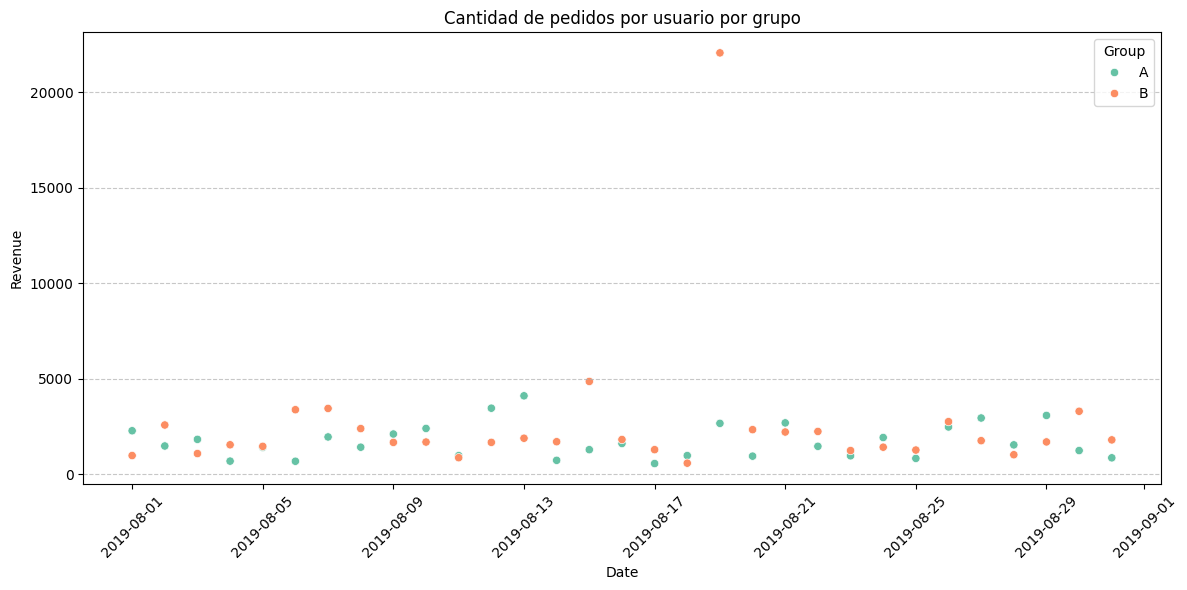

In [52]:
# Traza un gráfico de dispersión de los precios de los pedidos. Haz conclusiones y conjeturas.
# Agrupar por usuario y grupo mostrando la cantidad de pedidos por usuario por grupo
df_orders_price = df_orders.groupby(['date', 'group']).agg({'revenue': 'sum'}).reset_index() # agrupar por usuario y grupo mostrando la cantidad de pedidos por usuario por grupo
# Realizar graficar de dispersión
plt.figure(figsize=(12, 6))
sns.scatterplot(x='date', y='revenue', hue='group', data=df_orders_price, palette='Set2') # graficar
plt.title('Cantidad de pedidos por usuario por grupo')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend(title='Group')
plt.grid(axis='y', linestyle='--', alpha=0.7) # agregar una rejilla
plt.xticks(rotation=45) # rotar las etiquetas del eje x
plt.tight_layout() # ajustar la grafica
plt.show() # mostrar la grafica

Por la grafica mostrada podemos determinar que el grupo B tiene mayor numero de picos por lo que es el que mas ha recaudado. Ademas de que hay un valor muy por encima de los pedidos en general. 


8.- Calcula los percentiles 95 y 99 de los precios de los pedidos. Define el punto en el cual un punto de datos se convierte en una anomalía.

In [53]:

# Calcular percentiles 95 y 99 de los precios de los pedidos
# Calcular el percentil 95
percentil_95 = np.percentile(df_orders_price['revenue'], 95) # calcular el percentil 95
print('El percentil 95 es:', percentil_95) # imprimir el percentil 95
# Calcular el percentil 99
percentil_99 = np.percentile(df_orders_price['revenue'], 99) # calcular el percentil 99
print('El percentil 99 es:', percentil_99) # imprimir el percentil 99


El percentil 95 es: 3448.1400000000003
El percentil 99 es: 11563.50600000001


Los valores por encima de 3448 son valores anomalos mientras que estan por encima de 11,563 son definitivamente valores atipicos. 

9.- Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto. Haz conclusiones y conjeturas.

In [54]:

# Separar los grupos
df_orders_A = df_orders_copy[df_orders_copy['group'] == 'A'] # separar el grupo A
# Usuarios unicos del grupo A
users_unique_A = df_orders_A['visitorId'].nunique() # contar el total de visitante unicos del grupo A
# Total de usuarios del grupo A
total_users_A = df_orders_A['visitorId'].count() # contar el total de usuarios del grupo A

df_orders_B = df_orders_copy[df_orders_copy['group'] == 'B'] # separar el grupo B
# Usuarios unicos del grupo B
users_unique_B = df_orders_B['visitorId'].nunique() # contar el total de visitante unicos del grupo B  
# Total de usuarios del grupo B
total_users_B = df_orders_B['visitorId'].count() # contar el total de usuarios del grupo B

# porporcion de exito del grupo A
conversion_A = users_unique_A / total_users_A # calcular la proporcion de exito del grupo A
# porporcion de exito del grupo B
conversion_B = users_unique_B / total_users_B # calcular la proporcion de exito del grupo B

# prueba de hipotesis 
count = [users_unique_A, users_unique_B] # contar el total de pedidos del grupo A y B
nobs = [total_users_A, total_users_B] # contar el total de usuarios del grupo A y B

# Realizar la prueba de hipotesis
z_stat, p_value = proportions_ztest(count, nobs) # realizar la prueba de hipotesis
# Imprimir los resultados
print('Z-statistic:', z_stat) # imprimir el valor z
print('P-value:', p_value) # imprimir el valor p

# Comparar el valor p con el nivel de significancia
if p_value < alpha: # si el valor p es menor que el nivel de significancia
    print('Rechazamos la hipotesis nula; Sí hay diferencia estadisticamente significativa') # rechazar la hipotesis nula
else: # si el valor p es mayor que el nivel de significancia
    print('No rechazamos la hipotesis nula; No hay diferencia estadisticamente significativa')

Z-statistic: -0.7573131974557267
P-value: 0.44886224606171954
No rechazamos la hipotesis nula; No hay diferencia estadisticamente significativa


10.- Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto. Haz conclusiones y conjeturas.

In [55]:
# diferencia estadísticamente significativa en el tamaño promedio de pedido

alpha = 0.05 # nivel de significancia
# Separar pedidos por grupo
group_A = df_orders_copy[df_orders_copy['group'] == 'A']['revenue'] # separar el grupo A
group_B = df_orders_copy[df_orders_copy['group'] == 'B']['revenue'] # separar el grupo B

from scipy.stats import mannwhitneyu

stat, pval = mannwhitneyu(group_A, group_B, alternative='two-sided')

print(f'Estadístico U: {stat:.2f}')
print(f'Valor p: {pval:.4f}')

# Comparar el valor p con el nivel de significancia
if pval < alpha: # si el valor p es menor que el nivel de significancia
    print('Rechazamos la hipotesis nula; Sí hay diferencia estadisticamente significativa') # rechazar la hipotesis nula
else: # si el valor p es mayor que el nivel de significancia    
    print('No rechazamos la hipotesis nula; No hay diferencia estadisticamente significativa')

Estadístico U: 175872.50
Valor p: 0.6915
No rechazamos la hipotesis nula; No hay diferencia estadisticamente significativa


11.- Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados. Haz conclusiones y conjeturas.

In [56]:
# Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados. Haz conclusiones y conjeturas.

alpha = 0.05 # nivel de significancia

# Separar los grupos
df_orders_A = df_orders[df_orders['group'] == 'A'] # separar el grupo A
# Usuarios unicos del grupo A
users_unique_A = df_orders_A['visitorId'].nunique() # contar el total de visitante unicos del grupo A
# Total de usuarios del grupo A
total_users_A = df_orders_A['visitorId'].count() # contar el total de usuarios del grupo A

df_orders_B = df_orders[df_orders['group'] == 'B'] # separar el grupo B
# Usuarios unicos del grupo B
users_unique_B = df_orders_B['visitorId'].nunique() # contar el total de visitante unicos del grupo B  
# Total de usuarios del grupo B
total_users_B = df_orders_B['visitorId'].count() # contar el total de usuarios del grupo B

# porporcion de exito del grupo A
conversion_A = users_unique_A / total_users_A # calcular la proporcion de exito del grupo A
# porporcion de exito del grupo B
conversion_B = users_unique_B / total_users_B # calcular la proporcion de exito del grupo B

# prueba de hipotesis 
count = [users_unique_A, users_unique_B] # contar el total de pedidos del grupo A y B
nobs = [total_users_A, total_users_B] # contar el total de usuarios del grupo A y B

# Realizar la prueba de hipotesis
z_stat, p_value = proportions_ztest(count, nobs) # realizar la prueba de hipotesis
# Imprimir los resultados
print('Z-statistic:', z_stat) # imprimir el valor z
print('P-value:', p_value) # imprimir el valor p

# Comparar el valor p con el nivel de significancia
if p_value < alpha: # si el valor p es menor que el nivel de significancia
    print('Rechazamos la hipotesis nula; Sí hay diferencia estadisticamente significativa') # rechazar la hipotesis nula
else: # si el valor p es mayor que el nivel de significancia
    print('No rechazamos la hipotesis nula; No hay diferencia estadisticamente significativa')

Z-statistic: -0.9982144349533267
P-value: 0.31817538825989955
No rechazamos la hipotesis nula; No hay diferencia estadisticamente significativa


12.- Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados. Haz conclusiones y conjeturas.

In [57]:
# diferencia estadísticamente significativa en el tamaño promedio de pedido

# Separar pedidos por grupo
group_A = df_orders[df_orders['group'] == 'A']['revenue'] # separar el grupo A
group_B = df_orders[df_orders['group'] == 'B']['revenue'] # separar el grupo B

from scipy.stats import mannwhitneyu

stat, pval = mannwhitneyu(group_A, group_B, alternative='two-sided')

print(f'Estadístico U: {stat:.2f}')
print(f'Valor p: {pval:.4f}')

# Comparar el valor p con el nivel de significancia
if pval < alpha: # si el valor p es menor que el nivel de significancia
    print('Rechazamos la hipotesis nula; Sí hay diferencia estadisticamente significativa') # rechazar la hipotesis nula
else: # si el valor p es mayor que el nivel de significancia    
    print('No rechazamos la hipotesis nula; No hay diferencia estadisticamente significativa')

Estadístico U: 129041.50
Valor p: 0.8622
No rechazamos la hipotesis nula; No hay diferencia estadisticamente significativa
